In [15]:
import pydotplus
import numpy as np
import sklearn.datasets
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn import preprocessing
from IPython.display import Image, display
import MySQLdb

In [16]:
def get_data(cursor, query):
    cursor.execute(query)
    return cursor.fetchall()

In [17]:
def pack_master_data(master_data):
    return_data = []
    for d in master_data:
        return_data.append(d[0])
    return return_data

In [18]:
def display_image(clf, iris):
    dot_data = tree.export_graphviz(clf, out_file=None,
                                    feature_names=iris.feature_names,
                                    class_names=iris.target_names,
                                    filled=True, rounded=True)
 
    graph = pydotplus.graph_from_dot_data(dot_data)
    display(Image(data=graph.create_png()))

In [19]:
conn=MySQLdb.connect(host='103.236.201.20',user='skripsi_dev',passwd='tanyajob_dev', database='tanyajob')
cursor = conn.cursor()
query = """
    SELECT 
    users.name,
    master_degrees.id,
    master_majors.id,
    master_industries.id,
    YEAR(CURDATE()) - YEAR(users.date_of_birth) AS age,
    master_fields.id,
    master_locations.id,
    master_job_levels.id,
    work_experiences.salary_lower + salary_upper / 2 as average_salary,
    if (current = 1 OR work_experiences.started_work_at > work_experiences.ended_work_at, 
        DATEDIFF(CURDATE(),work_experiences.started_work_at), 
        DATEDIFF(work_experiences.ended_work_at,work_experiences.started_work_at)) / 30
    as work_duration
    FROM users
    JOIN work_experiences ON users.id = work_experiences.user_id
    JOIN master_degrees ON users.last_degree_id = master_degrees.id
    JOIN master_majors ON users.major_id = master_majors.id 
    JOIN master_industries ON master_industries.id = work_experiences.industry_id
    JOIN master_fields ON master_fields.id = work_experiences.field_id
    JOIN master_locations ON master_locations.id = work_experiences.location_id
    JOIN master_job_levels ON master_job_levels.id = work_experiences.job_level_id;
"""
query_degree = "SELECT name FROM master_degrees"
query_major = "SELECT name FROM master_majors"
query_industry = "SELECT name FROM master_industries"
query_field = "SELECT name FROM master_fields"
query_location = "SELECT name FROM master_locations"
query_job_level = "SELECT name FROM master_job_levels"

In [20]:
retrieved_data = get_data(cursor, query)
degree_data = get_data(cursor, query_degree)
major_data = get_data(cursor, query_major)
industry_data = get_data(cursor, query_industry)
field_data = get_data(cursor, query_field)
location_data = get_data(cursor, query_location)
job_level_data = get_data(cursor, query_job_level)

In [27]:
def train_model(collection):
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(collection.data, collection.target)
    return clf

In [28]:
collection = {}
temp_datas = []
temp_targets = []
for d in retrieved_data:
    temp_data = [d[1],d[2],d[3],d[4],d[5],d[6],d[7],d[9]]
    temp_target = str(d[8])
    temp_datas.append(temp_data)
    temp_targets.append(temp_target)
collection = sklearn.datasets.base.Bunch(
                data=np.array(temp_datas), 
                target=np.array(temp_targets),
                feature_names=["Last Degree", "Major", "Industry","Age","Fields","Locations","Job Levels","Work Duration"], 
                target_names=temp_targets)

In [29]:
decision_tree_classifier = train_model(collection)

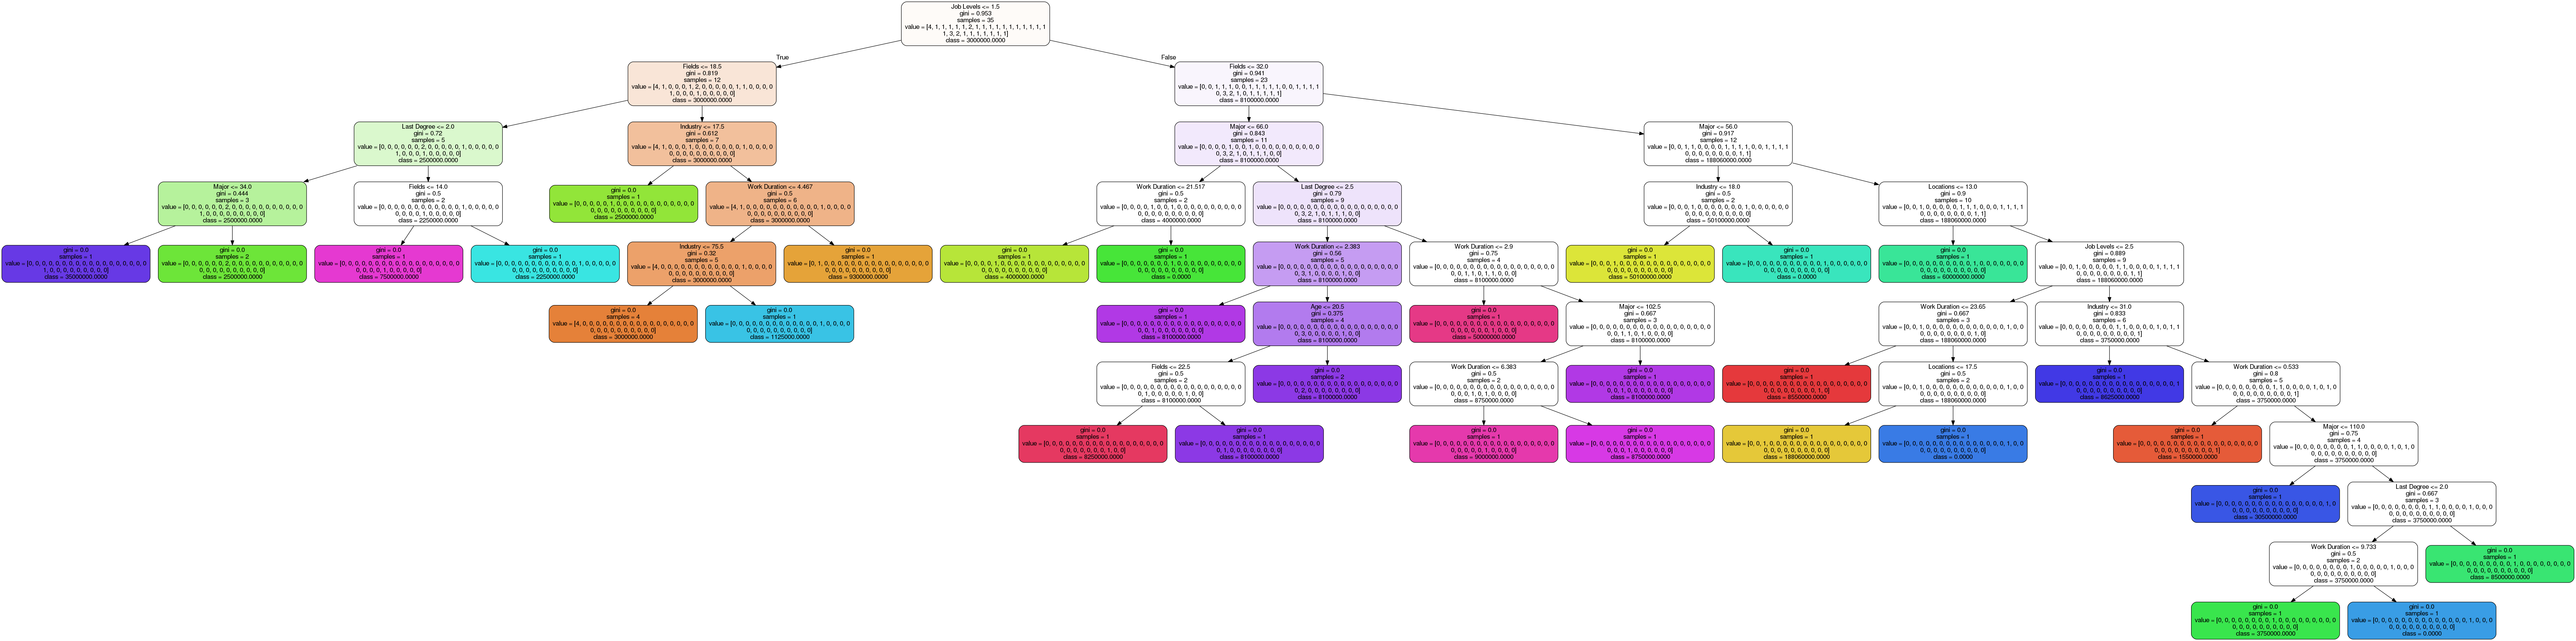

In [26]:
display_image(clf=decision_tree_classifier, iris=collection)